In [21]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

# simulation grid
nu = 1
L = 35
nx = 1024//4
nt = 4000//4

# initial conditions used for demo
T  = 300
x = np.linspace( 0, L,  nx)
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

simulation_params = {'nu': nu, 'L': L, 'nx': nx, 'nt': nt}

# plot the result
def plot_KS(u,T,nx=nx,nt=nt):
    x = np.linspace( 0, L, nx)
    t = np.linspace( 0, T, nt)
    fig, ax = plt.subplots(figsize=(10,8))

    xx, tt = np.meshgrid(x, t)
    levels = np.linspace(-3.5, 3.5, 300)
    cs = ax.contourf(xx, tt, u, levels, cmap='viridis')
    fig.colorbar(cs)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

In [2]:
def construct_integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
    dt = T/nt
    # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
    k = (2 * jnp.pi / L) * fftfreq(nx) * nx

    # solution mesh in real and Fourier space
    u      = jnp.empty((nt, nx), dtype=jnp.float64)
    u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
    u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

    # set initial condition in real and Fourier space
    u      = u     .at[0].set( u0 )
    u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
    u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

    # Fourier Transform of the linear and nonlinear operators
    FL = (k ** 2) - nu * (k ** 4)
    FN = - (1 / 2) * (1j) * k

    # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
    CN1 = (1 + (dt / 2) * FL)
    CN2 = 1 / (1 - (dt / 2) * FL)

    # first timestep (no advanced restarting, just Euler)
    u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

    # auxiliaries of first timestep
    u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
    u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

    # compute solution through time via finite difference method in Fourier space
    def finite_step(j, state):
        u, u_hat, u_hat2 = state
        # Cranck-Nicholson + Adams-Bashforth
        u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
        
        # go back to real space
        u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
        u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )
        return (u, u_hat, u_hat2)

    # compute solution through time via finite difference method in Fourier space
    u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2))[0]
    return jnp.real(u)
  
  return propagator

JAX_propagator = construct_integrator(**simulation_params)
u = JAX_propagator(u0,T)

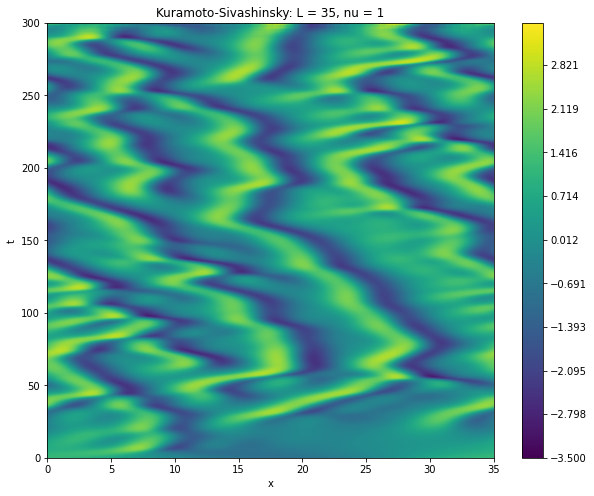

In [3]:
plot_KS(u,T)

Text(0.5, 1.0, 'error between states (dark is better)')

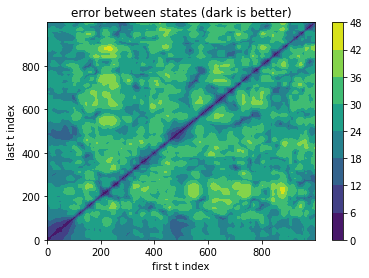

In [4]:
diff = np.linalg.norm(u[:,np.newaxis] - u[np.newaxis,:],axis=-1)
X, Y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
plt.contourf(diff, cmap='viridis')
diff[abs(X-Y)<0.1] += np.inf
plt.colorbar()
plt.xlabel('first t index')
plt.ylabel('last t index')
plt.title('error between states (dark is better)')

7.654376833146577
550 727


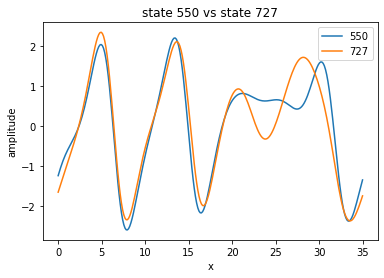

In [5]:
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(x,u[a],label=a)
plt.plot(x,u[b],label=b)
plt.xlabel('x')
plt.ylabel('amplitude')
plt.title(f"state {a} vs state {b}")
plt.legend()
print(np.linalg.norm(u[a] - u[b]))
print(a,b)

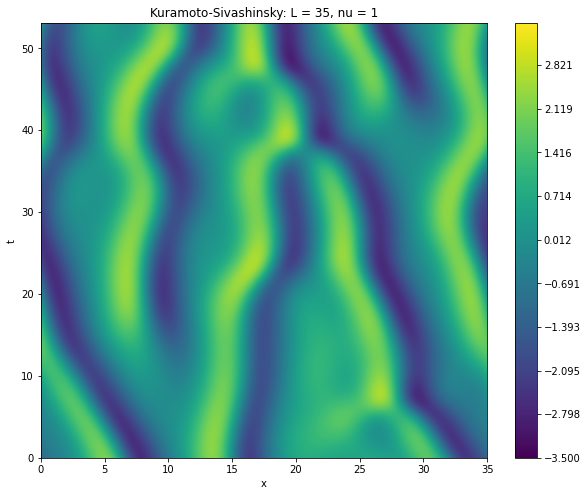

In [6]:
new_T = T * (b-a)/nt
u_new = JAX_propagator(u[a],new_T)
plot_KS(u_new, new_T)

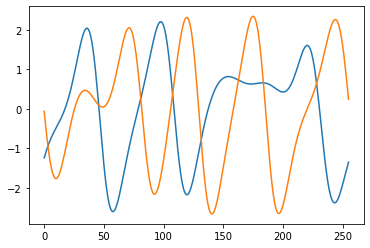

In [7]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [8]:
@jit
def residual(state):
    T, u0 = state[0], state[1:]
    prop  = JAX_propagator(u0,T)
    state = jnp.zeros((u0.shape[0] + 1,))
    state = state.at[0].set(0)
    state = state.at[1:].set(prop[0] - prop[-1])
    return state

def State(u0, T):
    state = jnp.zeros((u0.shape[0] + 1,))
    state = state.at[0].set(T)
    state = state.at[1:].set(u0)
    return state

In [9]:
@jit
def residual(u0):
    return u0 - JAX_propagator(u0,new_T)[-1]

In [10]:
def JAX_newton_krylov(res, u0, tol=1e-5):
    u = u0
    Jacobian_shape = (len(u0.flatten()), len(u0.flatten()))

    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    while magF > tol:
        J = linalg.LinearOperator(Jacobian_shape, matvec=lambda v: (jax.jvp(res, (u.flatten(),), (v,)))[1])
        f, e = linalg.lgmres(J,F.flatten(),inner_m=20,outer_k=10)
        u -= f.reshape(u.shape) * 0.01
        F = res(u)
        magF = np.linalg.norm(F)
        print(f"|F(x)| = {magF:.10f}")
    return u

# solve
guess = u[a] #State(u[a],new_T)
sol = scipy.optimize.newton_krylov(residual,guess, method='lgmres', verbose=1, rdiff=1e-7, iter=80)
print('Residual', abs(residual(sol)).max())

0:  |F(x)| = 3.5238; step 0.454
1:  |F(x)| = 3.1223; step 0.0549774
2:  |F(x)| = 3.26895; step 1
3:  |F(x)| = 3.3605; step 0.491453
4:  |F(x)| = 3.29896; step 0.0488432
5:  |F(x)| = 2.66257; step 0.413859
6:  |F(x)| = 2.55189; step 1
7:  |F(x)| = 2.65474; step 0.311274
8:  |F(x)| = 2.44723; step 0.129937
9:  |F(x)| = 2.30723; step 0.165782
10:  |F(x)| = 3.23334; step 1
11:  |F(x)| = 3.15109; step 1
12:  |F(x)| = 2.89915; step 0.288595
13:  |F(x)| = 2.87342; step 0.0260654
14:  |F(x)| = 2.8552; step 0.0241104
15:  |F(x)| = 2.78639; step 0.103795
16:  |F(x)| = 2.14936; step 0.293837
17:  |F(x)| = 1.98459; step 0.111031
18:  |F(x)| = 1.98261; step 0.111316
19:  |F(x)| = 1.84349; step 0.311645
20:  |F(x)| = 3.10211; step 1
21:  |F(x)| = 3.09952; step 1
22:  |F(x)| = 2.85667; step 0.117873
23:  |F(x)| = 2.59965; step 0.0452593
24:  |F(x)| = 2.9537; step 1
25:  |F(x)| = 2.93323; step 0.0567383
26:  |F(x)| = 2.44423; step 1
27:  |F(x)| = 2.30981; step 0.0654812
28:  |F(x)| = 2.26461; step 0.0

In [11]:
RPO = JAX_propagator(sol,new_T)

53.1


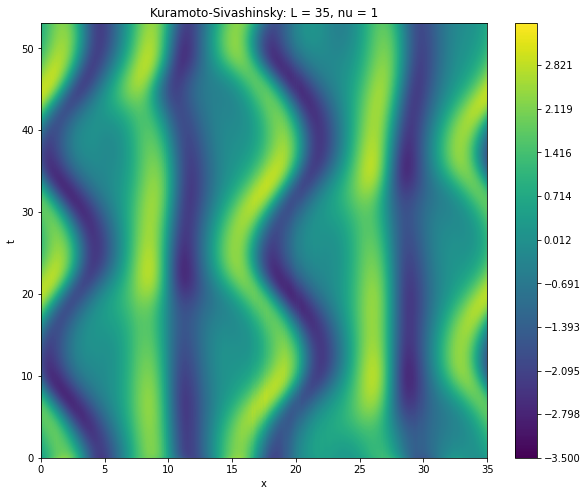

In [12]:
print(new_T)
plot_KS(RPO, new_T)

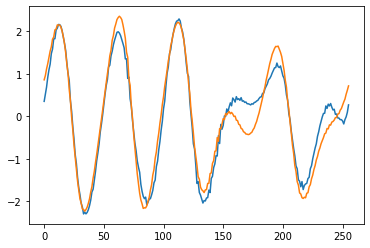

In [13]:
plt.plot(RPO[0])
plt.plot(RPO[-1])

In [14]:
exclusion = 0.1

mindiff = np.inf
minind  = (0,0)
x       = np.arange(0,nt,1)
for i in range(nt):
    diff = np.linalg.norm(RPO[:] - RPO[i], axis=-1)
    diff[abs(x-i)<exclusion*nt] += np.inf
    if np.min(diff) < mindiff:
        mindiff = np.min(diff)
        minind  = (i,np.argmin(diff))

a,b = min(minind), max(minind)

print(np.linalg.norm(RPO[a] - RPO[b]))
print(a,b)

2.490498401142796
272 746


2.490498401142796
272 746


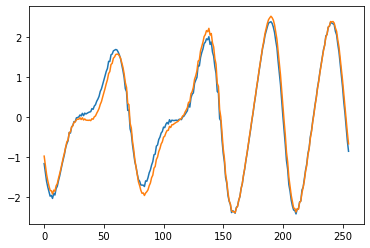

In [15]:
diff = np.linalg.norm(RPO[:,np.newaxis] - RPO[np.newaxis,:],axis=-1)
x, y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(x-y)<0.1] += np.inf
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(RPO[a])
plt.plot(RPO[b])
print(np.linalg.norm(RPO[a] - RPO[b]))
print(a,b)

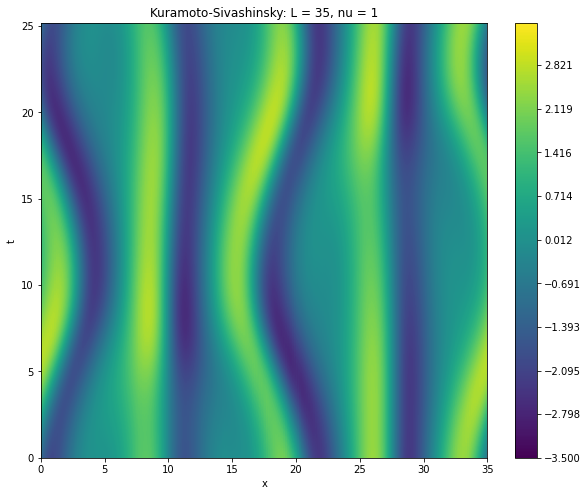

In [16]:
T_new = new_T * (b-a)/nt
u_new = JAX_propagator(RPO[a],T_new)
plot_KS(u_new, T_new)

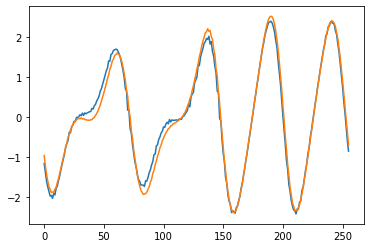

In [17]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [18]:
@jit
def residual(u0):
    return u0 - JAX_propagator(u0,T_new)[-1]

# solve
guess = RPO[a] #State(u[a],new_T)
sol = scipy.optimize.newton_krylov(residual, guess, method='lgmres', verbose=1, rdiff=1e-7, iter=80)
print('Residual', abs(residual(sol)).max())

0:  |F(x)| = 0.390695; step 0.00313356
1:  |F(x)| = 0.389561; step 0.00298296
2:  |F(x)| = 0.38848; step 0.00291004
3:  |F(x)| = 0.387433; step 0.00289421
4:  |F(x)| = 0.386404; step 0.00293275
5:  |F(x)| = 0.385376; step 0.00303823
6:  |F(x)| = 0.384322; step 0.00324726
7:  |F(x)| = 0.383195; step 0.00365473
8:  |F(x)| = 0.381883; step 0.00453071
9:  |F(x)| = 0.380146; step 0.00654956
10:  |F(x)| = 0.378611; step 0.00656527
11:  |F(x)| = 0.377747; step 0.00416699
12:  |F(x)| = 0.376746; step 0.00527319
13:  |F(x)| = 0.371484; step 0.0344881
14:  |F(x)| = 0.370434; step 0.142975
15:  |F(x)| = 0.38254; step 0.491499
16:  |F(x)| = 0.379352; step 0.500014
17:  |F(x)| = 0.37935; step 1
18:  |F(x)| = 0.379352; step 1
19:  |F(x)| = 0.37935; step 1
20:  |F(x)| = 0.379352; step 1
21:  |F(x)| = 0.37935; step 1
22:  |F(x)| = 0.379352; step 1
23:  |F(x)| = 0.37935; step 1
24:  |F(x)| = 0.379352; step 1
25:  |F(x)| = 0.367201; step 1
26:  |F(x)| = 0.387298; step 0.358542
27:  |F(x)| = 0.377608; st

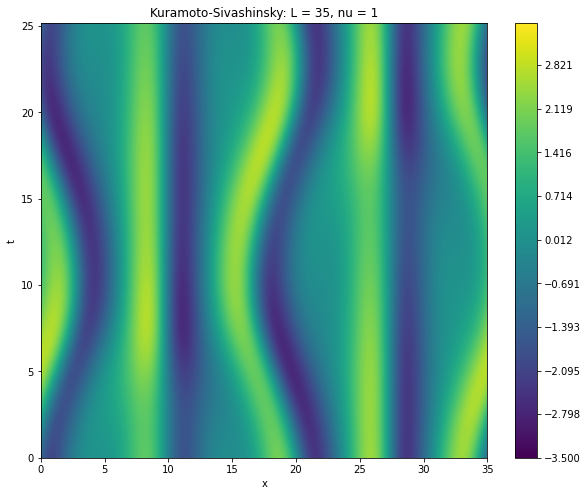

In [19]:
RPO2 = JAX_propagator(sol,T_new)
plot_KS(RPO2,T_new)

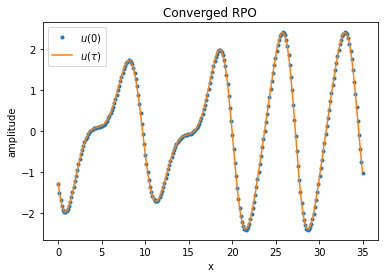

In [30]:
plt.plot(x,RPO2[0], '.', label=r'$u(0)$')
plt.plot(x,RPO2[-1],     label=r'$u(\tau)$')
plt.xlabel('x')
plt.ylabel('amplitude')
plt.title("Converged PO")
plt.legend()